# Visualization of the Pb boundary conditions based on transects along the boundaries

In [18]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib
import cmocean
from matplotlib.patches import ConnectionPatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from math import sin, cos, sqrt, atan2, radians
from matplotlib.ticker import MultipleLocator
import gsw
import xarray as xr

%matplotlib inline

#### Parameters

In [19]:
# domain dimensions:
imin, imax = 1139, 2179
jmin, jmax = 159, 799

# Rimwidths:
rimwidthN  = 10
rimwidthS  = 10
rimwidthW  = 10
rimwidthE  = 20

# Boundary coordinates: (i1,i2,j1,j2)
bdy_NCB = (1600,imax,jmax,jmax) # Northern Canada Basin
bdy_WCB = (imax,imax,391,jmax)  # Western Canada Basin
bdy_LS  = (imin,imin,449,674)   # Labrador Sea
bdy_HB  = (1189,1474,291,291)   # Hudson Bay

In [20]:
# Colors
land_color = '#a9a7a2'
color_sBB  = '#cc0e1d'
color_sGR  = '#ffb7aa'
light_gray = '#b1b1b1'
light_land = '#d0d0cf'
land_edge  = '#929291'

#### Files

In [21]:
mesh         = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon     = np.array(mesh.variables['nav_lon'])
mesh_lat     = np.array(mesh.variables['nav_lat'])
mesh_bathy   = np.array(mesh.variables['tmask'][0,:,:,:])
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = np.array(mesh.variables['nav_lev'])

Boundary Condition file:

In [51]:
BC     = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Pb_OBC_20220322.nc','r')
dPb_S  = np.array(BC.variables['dPb_S']).reshape(50,10,225)
dPb_N  = np.array(BC.variables['dPb_N']).reshape(50,10,408)
dPb_E  = np.array(BC.variables['dPb_E']).reshape(50,20,579)
dPb_W  = np.array(BC.variables['dPb_W']).reshape(50,10,285)

# Labrador Sea
dPb_S_lons = mesh_lon[bdy_LS[0]:bdy_LS[0]+rimwidthS,bdy_LS[2]:bdy_LS[3]] 
dPb_S_lats = mesh_lat[bdy_LS[0]:bdy_LS[0]+rimwidthS,bdy_LS[2]:bdy_LS[3]]
dPb_S_mdepths = bathy_masked[:,bdy_LS[0]:bdy_LS[0]+rimwidthS,bdy_LS[2]:bdy_LS[3]]

# Northern Canada Basin
dPb_E_lons = mesh_lon[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]+rimwidthE] 
dPb_E_lats = mesh_lat[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]+rimwidthE] 
dPb_E_mdepths = bathy_masked[:,bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]+rimwidthE] 

# Western Canada Basin
dPb_N_lons = mesh_lon[bdy_WCB[0]:bdy_WCB[0]+rimwidthN,bdy_WCB[2]:bdy_WCB[3]] 
dPb_N_lats = mesh_lat[bdy_WCB[0]:bdy_WCB[0]+rimwidthN,bdy_WCB[2]:bdy_WCB[3]]
dPb_N_mdepths = bathy_masked[:,bdy_WCB[0]:bdy_WCB[0]+rimwidthN,bdy_WCB[2]:bdy_WCB[3]]

# Hudson Bay
dPb_W_lons = mesh_lon[bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]+rimwidthW] 
dPb_W_lats = mesh_lat[bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]+rimwidthW] 
dPb_W_mdepths = bathy_masked[:,bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]+rimwidthW] 

print('Southern boundary dimensions:     ', \
      dPb_S.shape, dPb_S_lons.shape, dPb_S_lats.shape, dPb_S_mdepths.shape)
print('Northern Canada Basin boundary dimensions:     ', \
      dPb_E.shape, dPb_E_lons.shape, dPb_E_lats.shape, dPb_E_mdepths.shape)
print('Western Canada Basin boundary dimensions:     ', \
      dPb_N.shape, dPb_N_lons.shape, dPb_N_lats.shape, dPb_N_mdepths.shape)
print('Hudson Bay boundary dimensions:     ', \
      dPb_W.shape, dPb_W_lons.shape, dPb_W_lats.shape, dPb_W_mdepths.shape)

Southern boundary dimensions:      (50, 10, 225) (10, 225) (10, 225) (50, 10, 225)
Northern Canada Basin boundary dimensions:      (50, 20, 579) (579, 20) (579, 20) (50, 579, 20)
Western Canada Basin boundary dimensions:      (50, 10, 408) (10, 408) (10, 408) (50, 10, 408)
Hudson Bay boundary dimensions:      (50, 10, 285) (285, 10) (285, 10) (50, 285, 10)


#### Functions

In [25]:
# Convert lat/lon to distance along transect:
def calc_distance(lats, lons):
    R = 6373.0 # approximate radius of earth in km

    lats_rad = [radians(l) for l in lats]
    lons_rad = [radians(l) for l in lons]

    dlon = [lon_step - lons_rad[0] for lon_step in lons_rad]
    dlat = [lat_step - lats_rad[0] for lat_step in lats_rad]

    distance = np.empty((len(dlon)))
    for i in range(0,len(dlon)):
        a = sin(dlat[i] / 2)**2 + cos(lats_rad[0]) * cos(lats_rad[i]) * sin(dlon[i] / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance[i] = R * c
        
    return distance

#### Calculations

In [52]:
# Look at only one slice of the rimwidth thickness boundary:
S_distance  = calc_distance(dPb_S_lats[-1,:]   , dPb_S_lons[-1,:])    # Labrador Sea
N_distance  = calc_distance(dPb_N_lats[-1,:]   , dPb_N_lons[-1,:])    # western CB
E_distance  = calc_distance(dPb_E_lats[:,-1], dPb_E_lons[:,-1]) # northern CB
W_distance  = calc_distance(dPb_W_lats[:,-1], dPb_W_lons[:,-1]) # Hudson Bay

#### Figures

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(4.5*2, 3.7*1.5), dpi=300)

ax[0,0].set_title('Labrador Sea', fontsize=7)
ax[0,1].set_title('Hudson Bay', fontsize=7)
ax[1,0].set_title('Western Canada Basin', fontsize=7)
ax[1,1].set_title('Northern Canada Basin', fontsize=7)

ax[1,0].set_xlabel('Distance [km]', fontsize=6)
ax[1,1].set_xlabel('Distance [km]', fontsize=6)
ax[0,0].set_ylabel('Depth [m]', fontsize=6)
ax[1,0].set_ylabel('Depth [m]', fontsize=6)

for axis in ax.ravel():
    axis.invert_yaxis()
    axis.tick_params(axis='both', which='major', labelsize=6)
    
ax[0,0].set_ylim(3500,-10)
ax[0,1].set_ylim(500,-10)
ax[1,0].set_ylim(3000,-10)
ax[1,1].set_ylim(4000,-10)
    
bdy_cell = 0
cmap     = cmocean.cm.thermal

# Labrador Sea:
xx, zz = np.meshgrid(S_distance, depths)
CB1 = ax[0,0].pcolormesh(xx, zz, dPb_S[:,bdy_cell,:]*1e12, vmin=0, vmax=30, cmap=cmap)
ax[0,0].pcolormesh(xx, zz, dPb_S_mdepths[:,bdy_cell,:], cmap=matplotlib.colors.ListedColormap([land_color]))

# Hudson Bay: 
xx, zz = np.meshgrid(W_distance, depths)
CB2 = ax[0,1].pcolormesh(xx, zz, dPb_W[:,bdy_cell,:]*1e12, vmin=0, vmax=8, cmap=cmap)
ax[0,1].pcolormesh(xx, zz, dPb_W_mdepths[:,:,bdy_cell], cmap=matplotlib.colors.ListedColormap([land_color]))

# Western Canada Basin:
xx, zz = np.meshgrid(N_distance, depths)
CB3 = ax[1,0].pcolormesh(xx, zz, dPb_N[:,bdy_cell,:]*1e12, vmin=0, vmax=8, cmap=cmap)
ax[1,0].pcolormesh(xx, zz, dPb_N_mdepths[:,bdy_cell,:], cmap=matplotlib.colors.ListedColormap([land_color]))

# Northern Canada Basin:
xx, zz = np.meshgrid(E_distance, depths)
CB4 = ax[1,1].pcolormesh(xx, zz, dPb_E[:,bdy_cell,:]*1e12, vmin=0, vmax=8, cmap=cmap)
ax[1,1].pcolormesh(xx, zz, dPb_E_mdepths[:,:,bdy_cell], cmap=matplotlib.colors.ListedColormap([land_color]))

# add text labels:
fig.text(0.13, 0.89, 'a)', fontsize=8, weight='bold');
fig.text(0.55, 0.89, 'b)', fontsize=8, weight='bold');
fig.text(0.13, 0.48, 'c)', fontsize=8, weight='bold');
fig.text(0.55, 0.48, 'd)', fontsize=8, weight='bold');

cbax1 = fig.add_axes([0.13 , 0.55, 0.01, 0.12]);
cbax2 = fig.add_axes([0.555, 0.55, 0.01, 0.12]);
cbax3 = fig.add_axes([0.13 , 0.14, 0.01, 0.12]);
cbax4 = fig.add_axes([0.555, 0.14, 0.01, 0.12]);
cbaxes = [cbax1, cbax2, cbax3, cbax4]

for n,cb in enumerate([CB1, CB2, CB3, CB4]):
    if n > 0:
        CBar = plt.colorbar(cb, ax=ax, cax=cbaxes[n], ticks=[0,2,4,6,8]); 
    else:
        CBar = plt.colorbar(cb, ax=ax, cax=cbaxes[n]); 
    CBar.set_label('Dissolved Pb [pM]', fontsize=6)
    CBar.ax.tick_params(axis='y', length=0, labelsize=6)

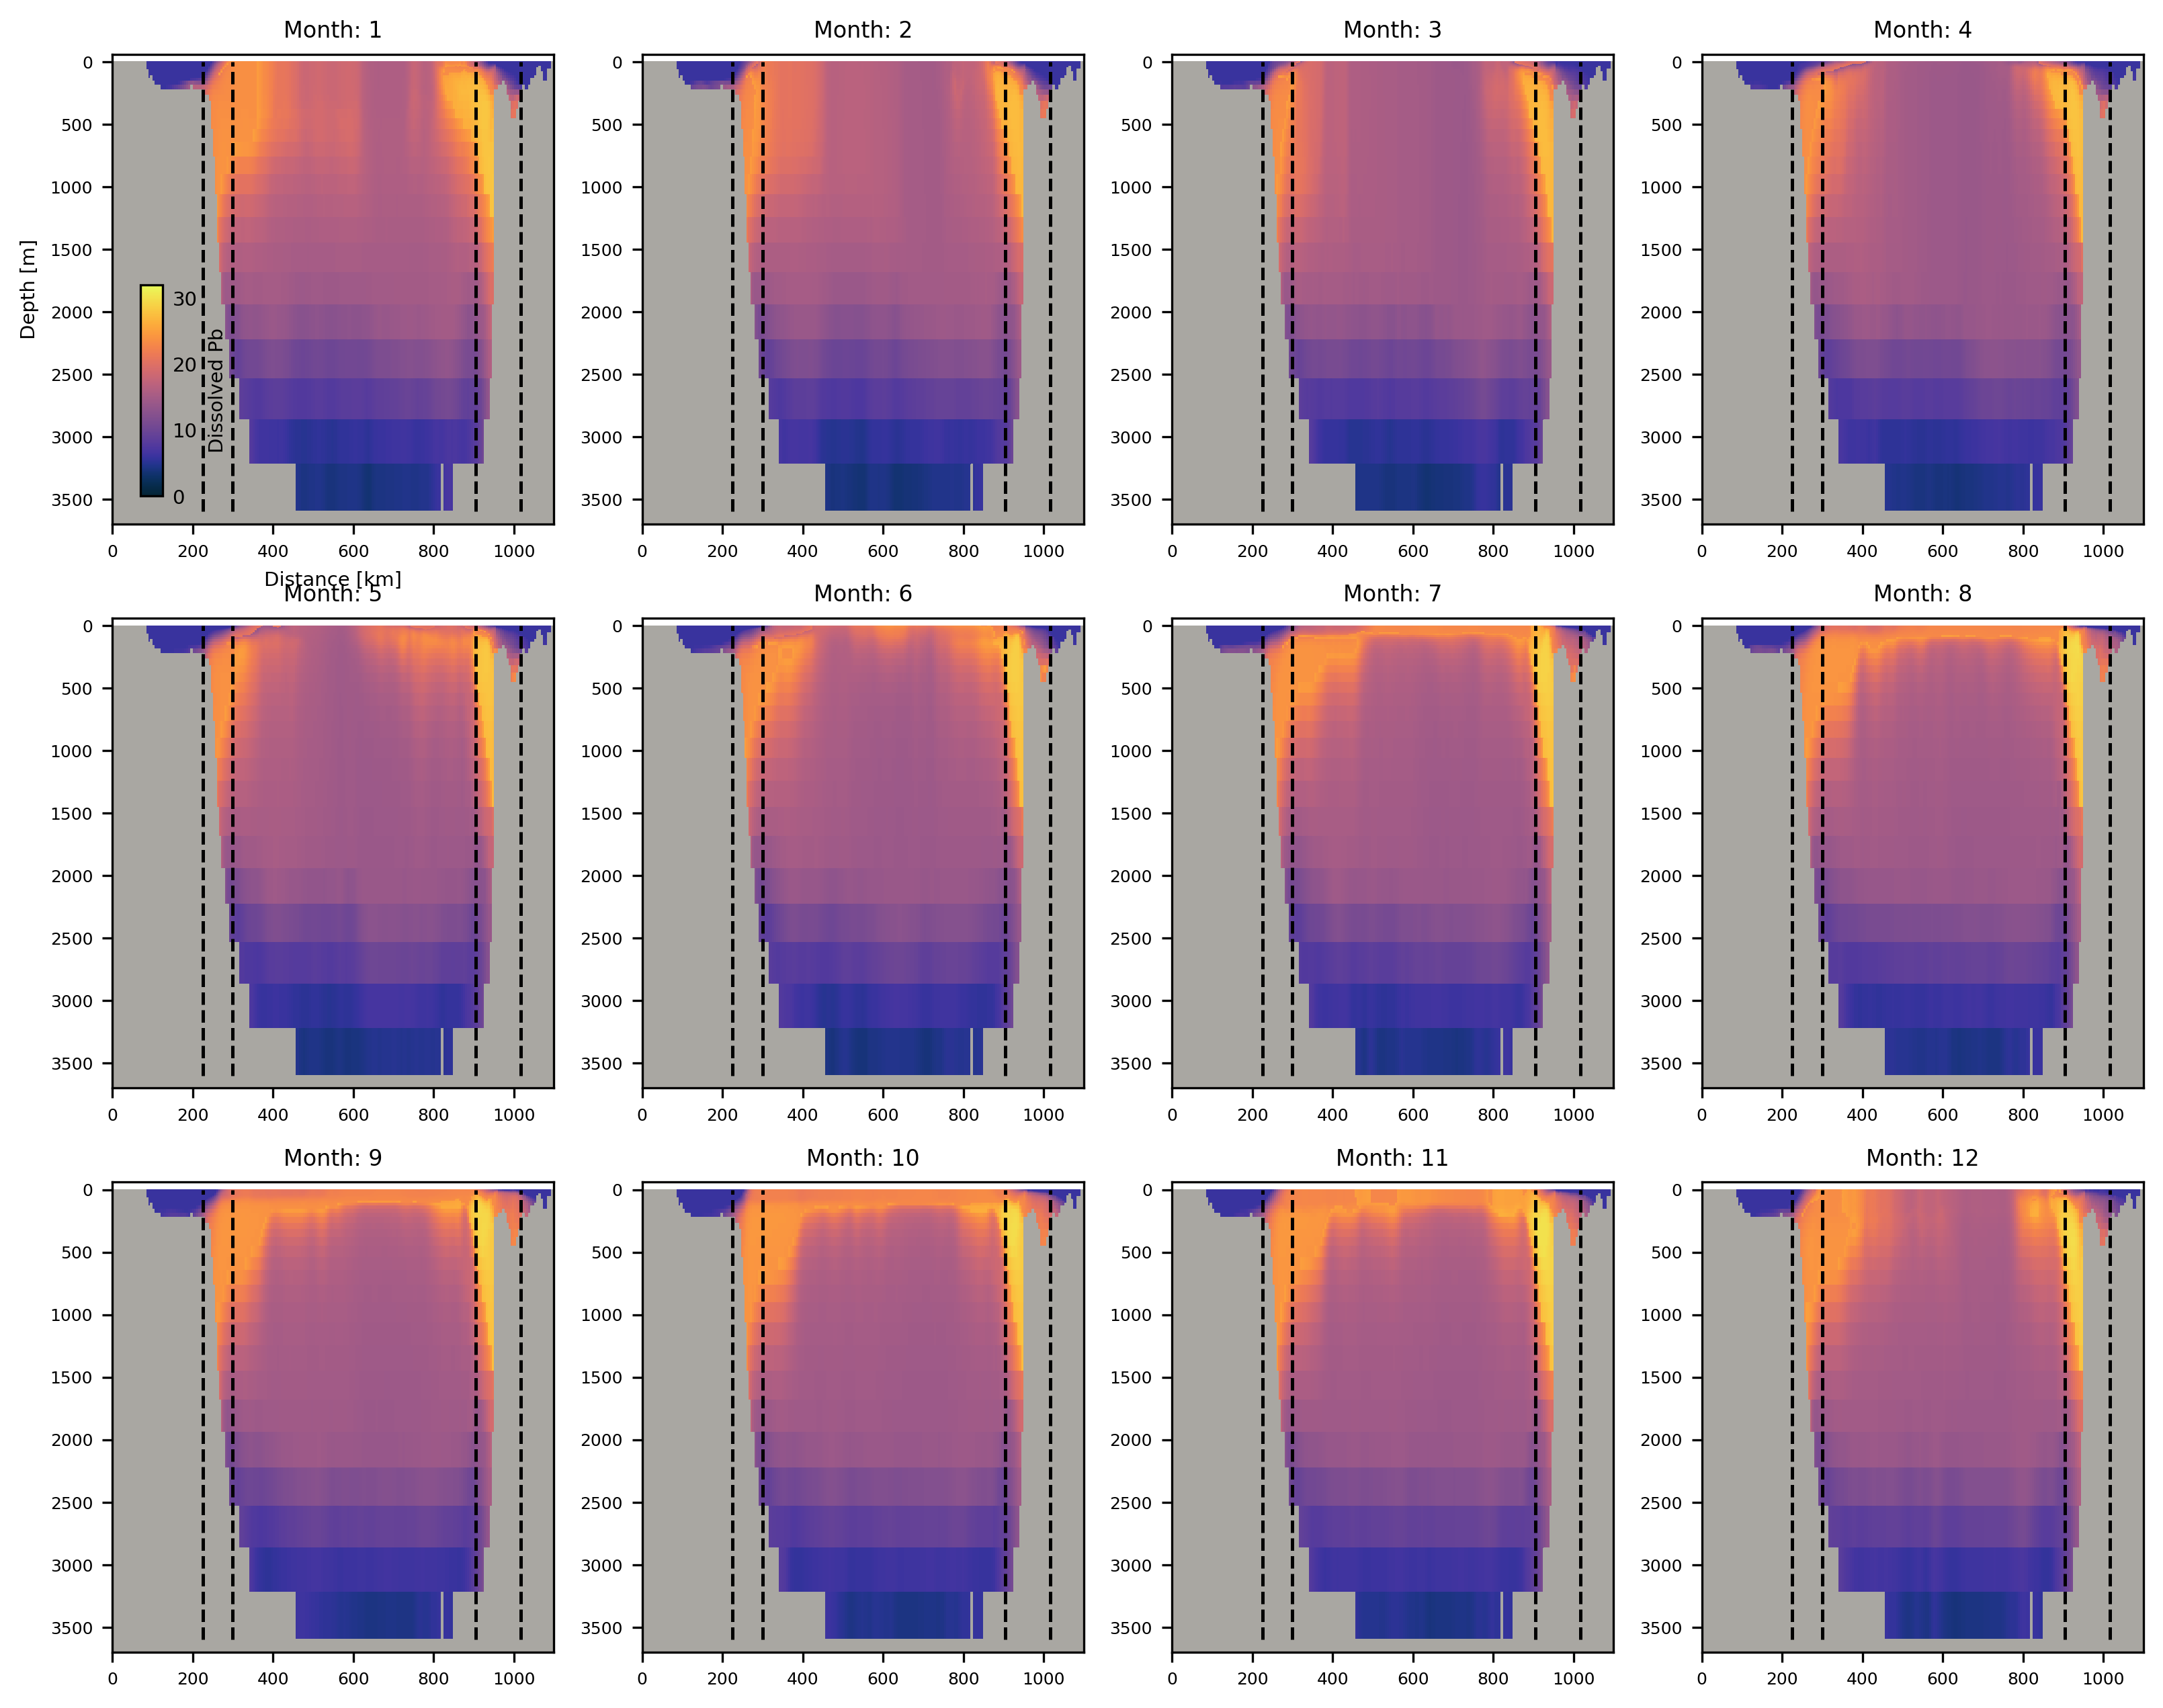

In [46]:
fig, ax = plt.subplots(3,4, figsize=(13, 10.5), dpi=300)

axes = ax.ravel()

for month in range(0,12):
   
    if month > 0:
        plot_transect(axes[month], dPb_BB[month,:,:,:]*1e12, vrange=(0,32), label='Dissolved Pb', cmap=cmocean.cm.thermal, labelling=False)
    else:
        plot_transect(axes[month], dPb_BB[month,:,:,:]*1e12, vrange=(0,32), label='Dissolved Pb', cmap=cmocean.cm.thermal, labelling=True)
        
    axes[month].set_title(f'Month: {month+1}', fontsize=8)
    add_lines(axes[month])
    
fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb_explorations/LS_boundary_conditions_2015.jpg', dpi=300, bbox_inches='tight')

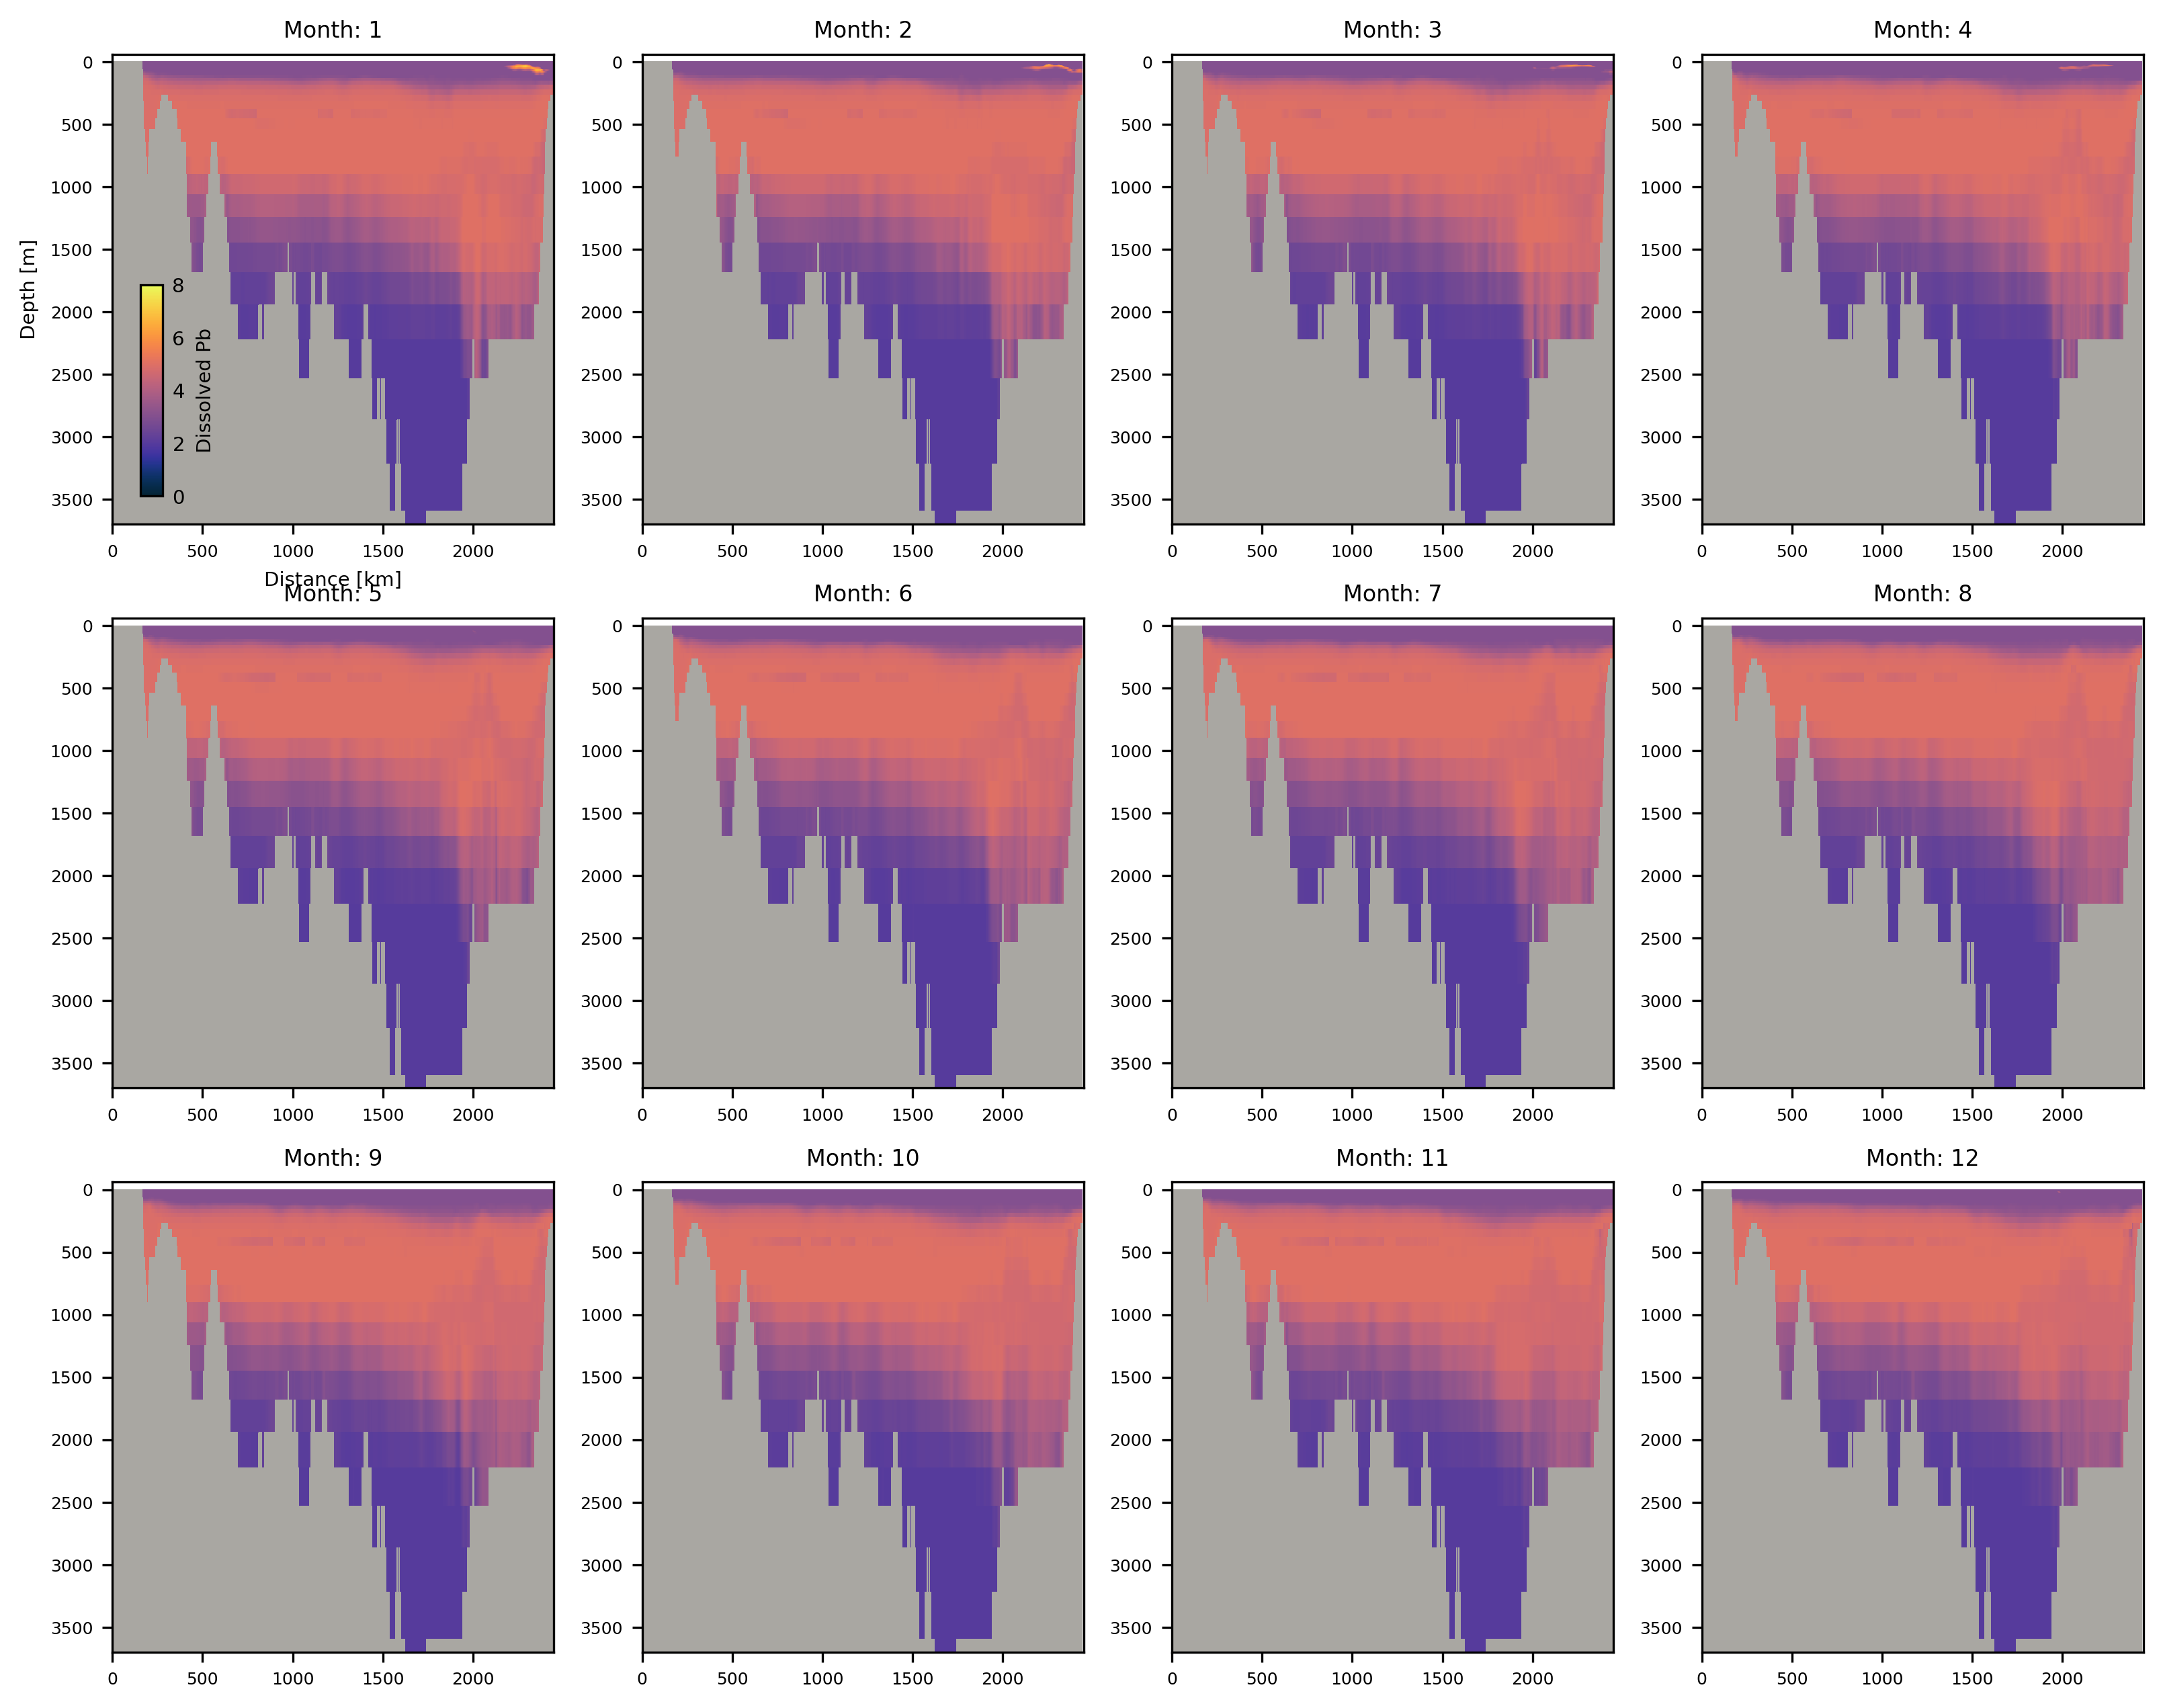

In [132]:
fig, ax = plt.subplots(3,4, figsize=(13, 10.5), dpi=300)

axes = ax.ravel()

for month in range(0,12):
   
    if month > 0:
        plot_nCB_transect(axes[month], dPb_nCB[month,:,:,:]*1e12, vrange=(0,8), xlim=(0,2450), \
                          label='Dissolved Pb', cmap=cmocean.cm.thermal, labelling=False)
    else:
        plot_nCB_transect(axes[month], dPb_nCB[month,:,:,:]*1e12, vrange=(0,8), xlim=(0,2450), \
                          label='Dissolved Pb', cmap=cmocean.cm.thermal, labelling=True)
        
    axes[month].set_title(f'Month: {month+1}', fontsize=8)
    
fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb_explorations/nCB_boundary_conditions_2015.jpg', dpi=300, bbox_inches='tight')

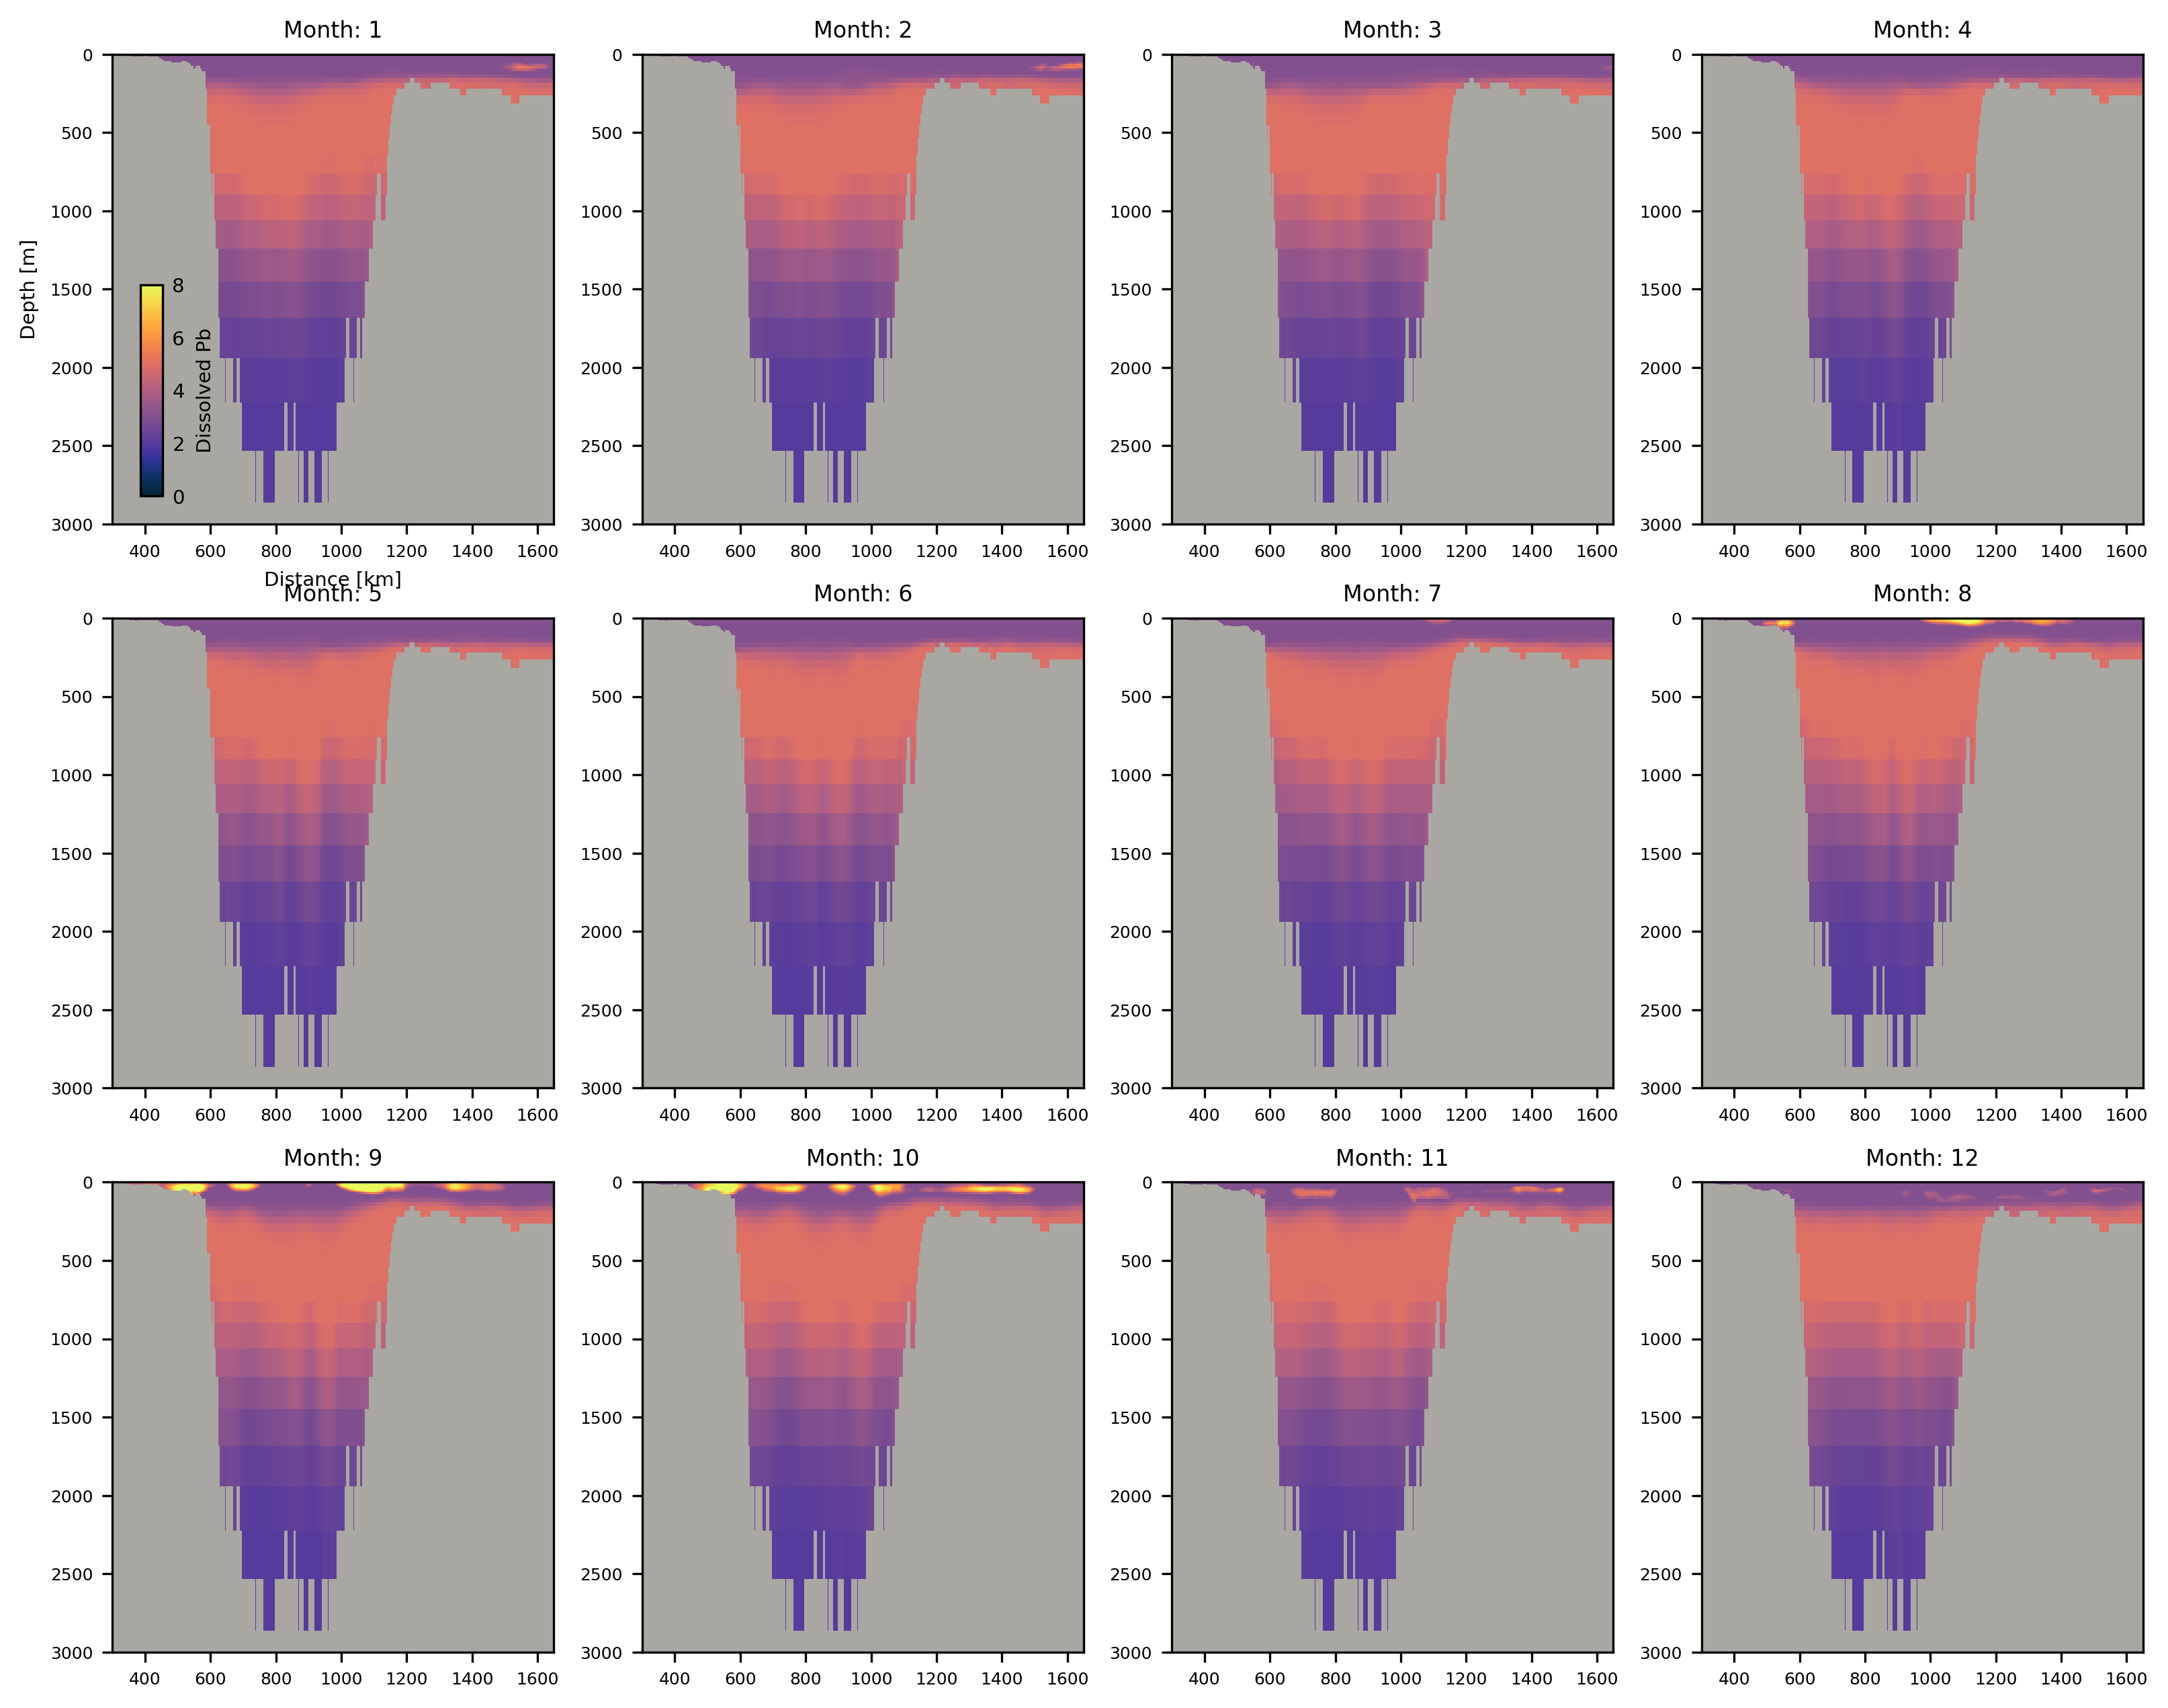

In [119]:
fig, ax = plt.subplots(3,4, figsize=(13, 10.5), dpi=300)

axes = ax.ravel()

for month in range(0,12):
   
    if month > 0:
        plot_wCB_transect(axes[month], dPb_wCB[month,:,:,:]*1e12, vrange=(0,8), label='Dissolved Pb', 
                          xlim=(300,1650), ylim=(3000,0), cmap=cmocean.cm.thermal, labelling=False)
    else:
        plot_wCB_transect(axes[month], dPb_wCB[month,:,:,:]*1e12, vrange=(0,8), label='Dissolved Pb', 
                          xlim=(300,1650), ylim=(3000,0), cmap=cmocean.cm.thermal, labelling=True)
        
    axes[month].set_title(f'Month: {month+1}', fontsize=8)
    
fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb_explorations/wCB_boundary_conditions_2015.jpg', dpi=300, bbox_inches='tight')